In [23]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
import warnings

from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import qqplot, add_constant
from sklearn.metrics import r2_score
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
import statsmodels.api as sm


%matplotlib inline
warnings.filterwarnings('ignore')
import platform
plt.rcParams['font.family'] = 'NanumGothic' 
matplotlib.rcParams['axes.unicode_minus'] = False

In [24]:
# Power 기준 차량 크기 구분하는 함수
# 경차 -> 1000 미만
# 소형 -> 1600 미만
# 중형 -> 2000 미만
# 대형 -> 2000 이상
def car_size(cc):
    if cc >= 2000:
        car_size = 'full'
    elif cc >= 1600:
        car_size = 'mid'
    elif cc > 1000:
        car_size = 'small'
    else:
        car_size = 'light'
        
    return car_size

In [25]:
# Name열 split 후 회사명(브랜드)만 리턴하는 함수
def extract_brand(text):
    return text.split()[0]

# 전체 과정
1. 도메인 정보 파악
2. 전처리
3. EDA
4. 모델링
5. 핵심 인자 도출
6. 경쟁력 확보 방안 도출

# 1. 도메인 정보 파악 - pass

# 2. 데이터 전처리
1) 데이터 불러오기 / 요약정보 파악
2) 결측치 처리
3) 이상치 처리
4) 컬럼 특성 파악 및 전처리
    - Name
    - Location
    - Price
    - Year
    - Kilometers_driven
    - Fuel_Type
    - Owner_Type
    - Mileage
    - Engine
    - Power
    - Seats

In [26]:
# 1) 데이터 불러오기
df = pd.read_csv('/home/piai/다운로드/2주차 실습파일/2. Big Data 분석/Car.csv')
df.head()

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price
0,Maruti Wagon R LXI CNG,Mumbai,2682.68,2010,72000,CNG,Manual,First,26.6 kmpl,998 CC,58.16 bhp,5.0,NaN
1,Hyundai Creta 1.6 CRDi SX Option,Pune,19162.00,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN
2,Honda Jazz V,Chennai,6898.32,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh
3,Maruti Ertiga VDI,Chennai,9197.76,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,27194.71,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN


In [27]:
# 요약정보
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Price              6200 non-null   float64
 3   Year               7253 non-null   int64  
 4   Kilometers_Driven  7253 non-null   int64  
 5   Fuel_Type          7253 non-null   object 
 6   Transmission       7253 non-null   object 
 7   Owner_Type         7253 non-null   object 
 8   Mileage            7251 non-null   object 
 9   Engine             7207 non-null   object 
 10  Power              7207 non-null   object 
 11  Seats              7200 non-null   float64
 12  New_Price          1006 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 736.8+ KB


### 데이터 설명
* 목표변수
    - Price 중고차 가격(단위 : 1,000원)
* 설명변수
   - Name : 자동차 브랜드와 모델의 이름
   - Location : 자동차를 팔거나 구매할 수 있는 위치
   - Year : 모델의 년도 혹은 버전
   - Kilometers_Driven : 이전 소유주의 차량 주행거리(Km)
   - Fuel_Type : 자동차의 사용연료의 종류
   - Transmission : 자동차의 사용 변속기 종류(Manual/Automatic)
   - Owner_Type : 소유권이 직접 소유인지, 중고 소유인지 여부
   - Mileage : 자동차 회사가 제공하는 표준주행거리(kmpl)
   - Engine : 엔진의 배기량(cc)
   - Power : 엔진의 최대 출력(bhp)
   - Seats : 차의 좌석 수
   - New_Price : 뉴 모델의 가격

In [28]:
df.describe() # 수치형 변수 기술통계량

,Price,Year,Kilometers_Driven,Seats
count,6200.000000,7253.000000,7.253000e+03,7200.000000
mean,14912.514750,2013.365366,5.869906e+04,5.279722
std,17674.318464,3.254421,8.442772e+04,0.811660
min,7.080000,1996.000000,1.710000e+02,0.000000
25%,5365.360000,2011.000000,3.400000e+04,5.000000
50%,8814.520000,2014.000000,5.341600e+04,5.000000
75%,15869.972500,2016.000000,7.300000e+04,5.000000
max,245273.600000,2019.000000,6.500000e+06,10.000000


### 결측치

In [29]:
# 결측치 확인
df.isnull().sum()

Name                    0
Location                0
Price                1053
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 46
Power                  46
Seats                  53
New_Price            6247
dtype: int64

- New_Price : 결측치가 6247개로 전체 7253개 중 약 86.1%로 큰 비중을 차지하고, 열 특성 자체가 가격 예측에 영향을 주지 않을 것이라 판단되어 열 자체 제거
- Mileage, Engine, Power, Seats : 결측치의 개수가 적어 결측치가 예측에 큰 영향을 주지 않을 것이라 판단되어 결측치에 해당하는 행만 제거
- Price : 1053개의 결측치가 존재하지만, 목표변수에 해당하므로 따로 보간하지 않고 결측치 존재 행 제거

In [30]:
# Price 결측치 제거
df.dropna(subset=['Price'], inplace=True)
df[df['Price'].isna()]

,Name,Location,Price,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price


In [31]:
# New_Price 컬럼 제거
df.drop('New_Price',axis=1,inplace=True)

In [32]:
# Mileage / Engine / Power / Seats 결측치 제거
df.dropna(subset=['Mileage','Engine','Power','Seats'],axis=0,inplace=True)

### 이상치

In [33]:
# Power 열 null bhp 제거
# 수치상 null은 이상치로 판단하고 제거
df[df['Power'] == 'null bhp'] 
df = df[df['Power'] != 'null bhp'] # 제거

<Axes: >

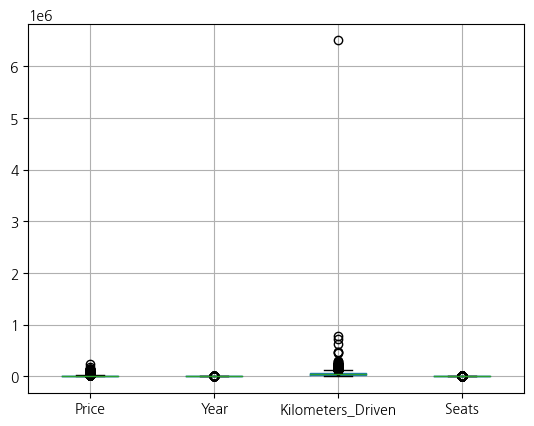

In [34]:
df.boxplot()

- Kilometers_Driven에서 이상치로 판단되는 값이 하나 확인됨.
- 이외에 아직 이상치 판단하기 어려움이 있어 데이터 파악 후 추후 처리 진행 예정.

### 단위제거 및 형변환
- 단위 들어가 있는 컬럼 단위 제거 후 수치형으로 변환
- ex. Mileage : 17.8 kmpl -> 17.8

In [35]:
df['Mileage'] = df['Mileage'].str.replace('kmpl','').astype('float')
df['Engine'] = df['Engine'].str.replace('CC','').astype('float')
df['Power'] = df['Power'].str.replace('bhp','').astype('float')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6053 entries, 0 to 7236
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6053 non-null   object 
 1   Location           6053 non-null   object 
 2   Price              6053 non-null   float64
 3   Year               6053 non-null   int64  
 4   Kilometers_Driven  6053 non-null   int64  
 5   Fuel_Type          6053 non-null   object 
 6   Transmission       6053 non-null   object 
 7   Owner_Type         6053 non-null   object 
 8   Mileage            6053 non-null   float64
 9   Engine             6053 non-null   float64
 10  Power              6053 non-null   float64
 11  Seats              6053 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 614.8+ KB


### 파생변수 생성

In [37]:
df.Name.nunique()
# Name의 unique의 개수가 너무 많아 분석 및 판단에 이상이 있을 것이라 생각됨.
# Name에서 Brand명만 구분하여 사용하는 Brand 파생변수 생성

1856

In [38]:
df['Brand'] = df['Name'].apply(extract_brand)
df['Brand'].head()

0     Maruti
1    Hyundai
2      Honda
3     Maruti
4       Audi
Name: Brand, dtype: object

In [39]:
# Name 변수 제거
df.drop('Name',axis=1,inplace=True)

In [40]:
df.Brand.nunique()

29

In [41]:
df['Brand'].value_counts()

Maruti           1218
Hyundai          1079
Honda             614
Toyota            406
Mercedes-Benz     323
Volkswagen        320
Ford              298
Mahindra          278
BMW               268
Audi              240
Tata              192
Skoda             181
Renault           151
Chevrolet         120
Nissan             93
Land               57
Jaguar             43
Mitsubishi         34
Mini               29
Fiat               26
Volvo              21
Jeep               19
Datsun             17
Porsche            16
ISUZU               3
Force               3
Bentley             2
Ambassador          1
Lamborghini         1
Name: Brand, dtype: int64

In [42]:
df['Brand'].value_counts().sum()

6053

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 [Text(0, 0, 'Maruti'),
  Text(1, 0, 'Hyundai'),
  Text(2, 0, 'Honda'),
  Text(3, 0, 'Audi'),
  Text(4, 0, 'Nissan'),
  Text(5, 0, 'Toyota'),
  Text(6, 0, 'Volkswagen'),
  Text(7, 0, 'Tata'),
  Text(8, 0, 'Land'),
  Text(9, 0, 'Mitsubishi'),
  Text(10, 0, 'Renault'),
  Text(11, 0, 'Mercedes-Benz'),
  Text(12, 0, 'BMW'),
  Text(13, 0, 'Mahindra'),
  Text(14, 0, 'Ford'),
  Text(15, 0, 'Porsche'),
  Text(16, 0, 'Datsun'),
  Text(17, 0, 'Jaguar'),
  Text(18, 0, 'Volvo'),
  Text(19, 0, 'Chevrolet'),
  Text(20, 0, 'Skoda'),
  Text(21, 0, 'Mini'),
  Text(22, 0, 'Fiat'),
  Text(23, 0, 'Jeep'),
  Text(24, 0, 'Ambassador'),
  Text(25, 0, 'ISUZU'),
  Text(26, 0, 'Force'),
  Text(27, 0, 'Bentley'),
  Text(28, 0, 'Lamborghini')])

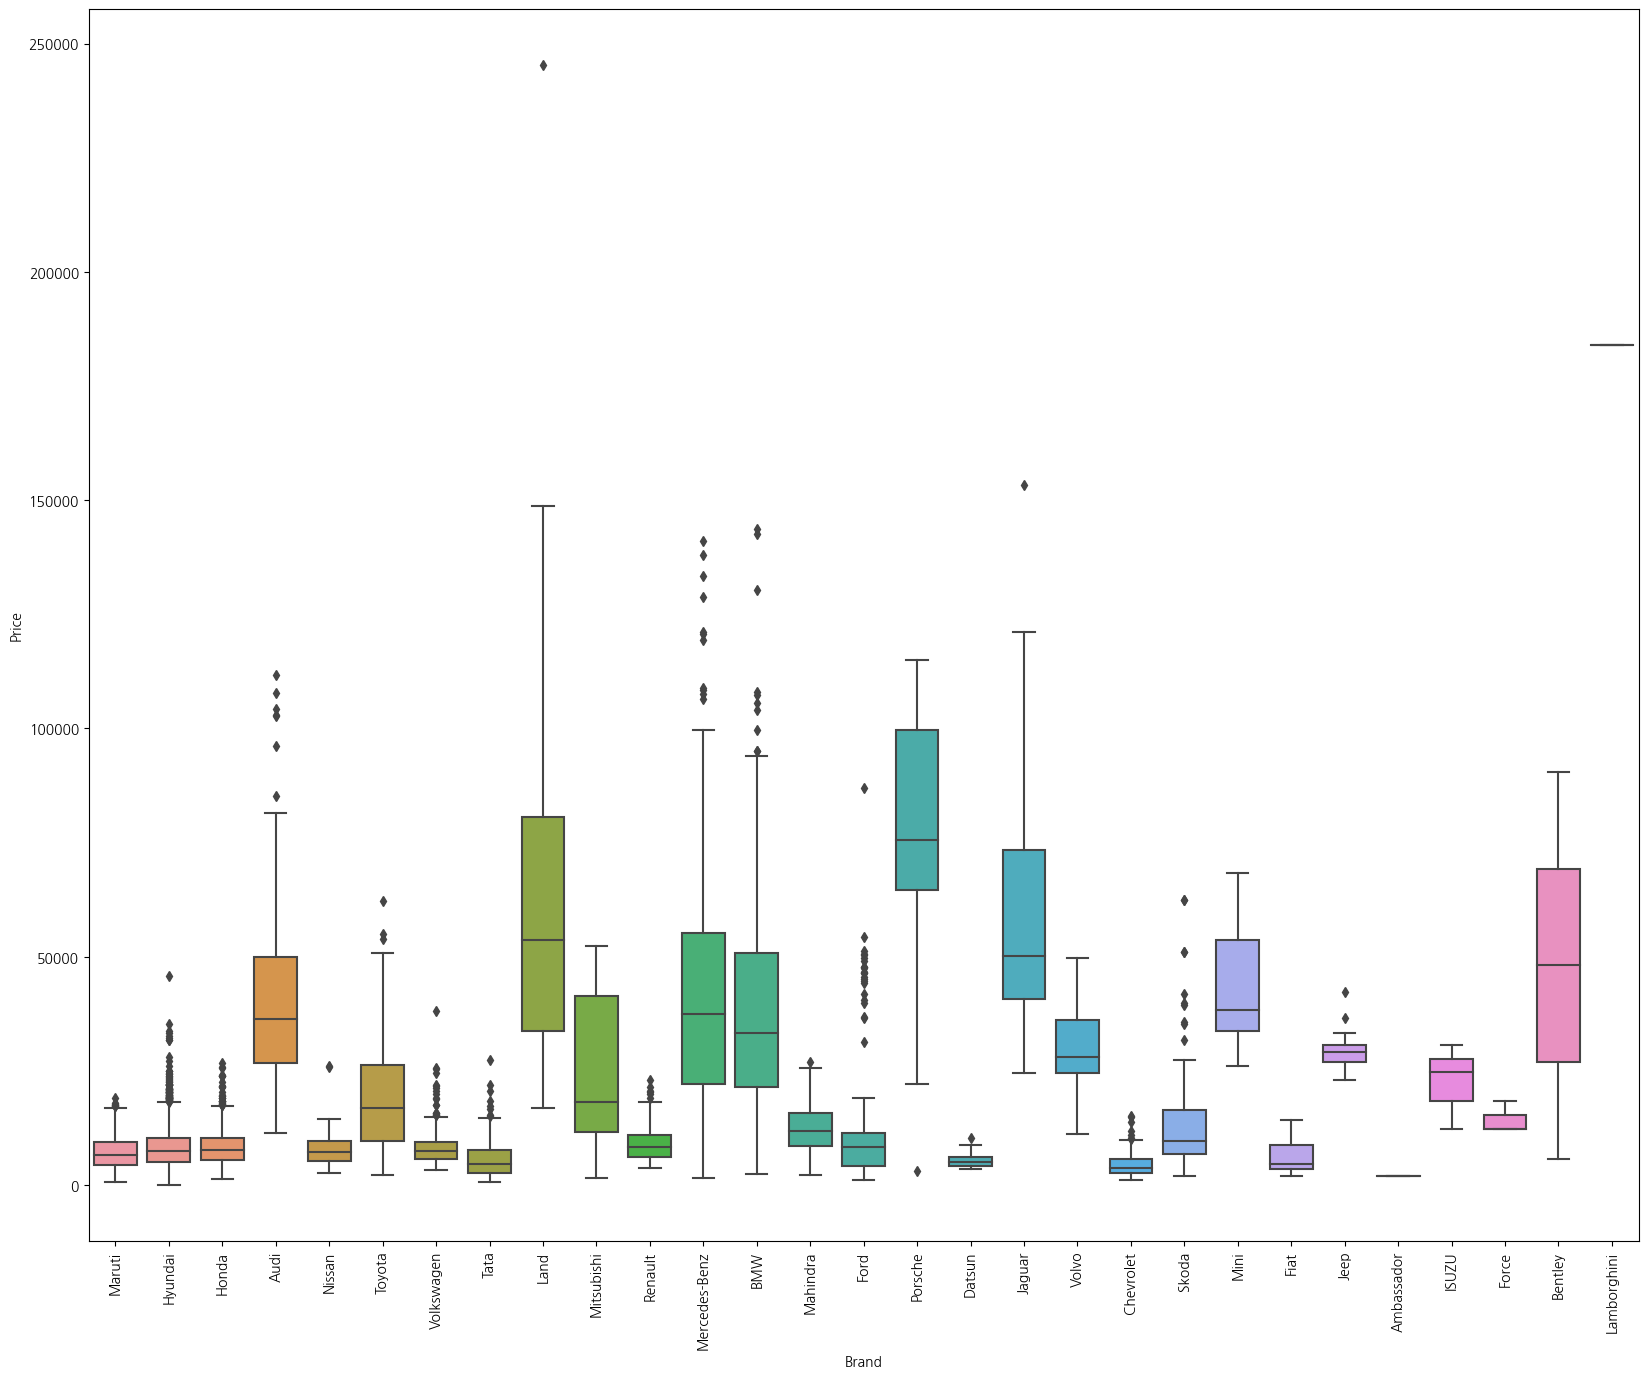

In [43]:
plt.figure(figsize=(20,16))
sns.boxplot(x='Brand',y='Price',data=df)
plt.xticks(rotation=90)

In [44]:
# Engine(배기량)을 기준으로 차량의 사이즈를 구분하는 Size 파생변수 생성
df['Size']= df['Engine'].apply(car_size)

In [45]:
df['Size'].head()

0    light
1    small
2    small
3    small
4      mid
Name: Size, dtype: object

Text(0.5, 1.0, 'Seats')

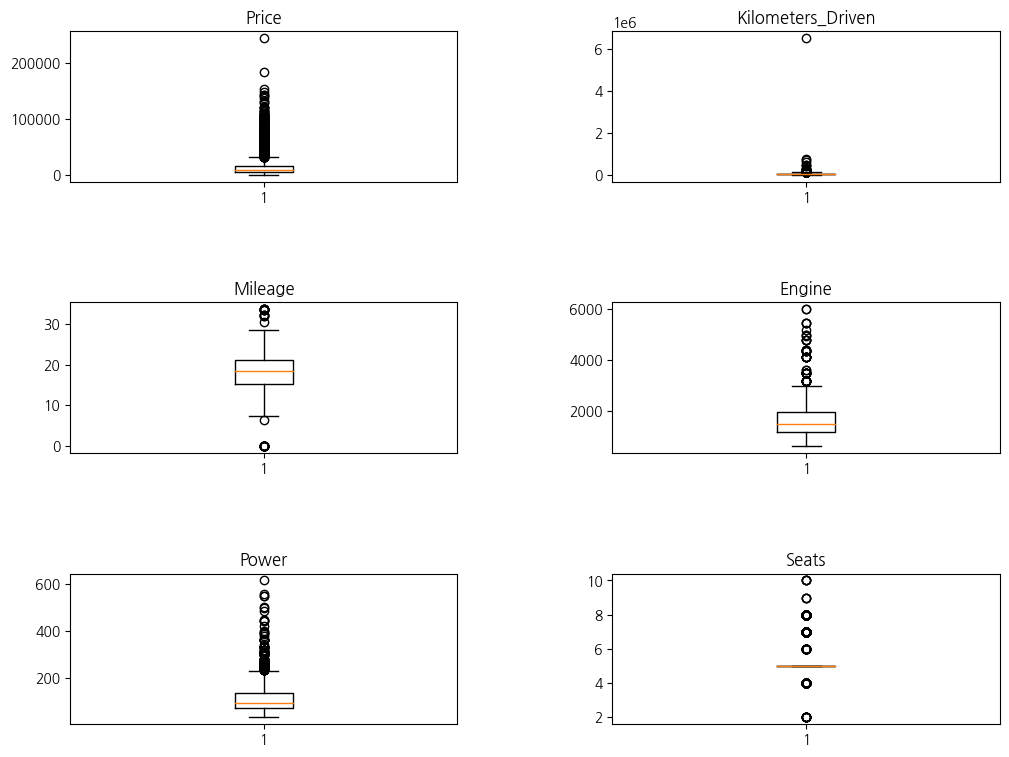

In [46]:
#이상치 재확인을 위한 box-plot
fig, axs = plt.subplots(3, 2, figsize=(12, 9))
axs = axs.flatten()

fig.subplots_adjust(wspace=0.4, hspace=0.8)

axs[0].boxplot(df['Price'])
axs[0].set_title('Price')

axs[1].boxplot(df['Kilometers_Driven'])
axs[1].set_title('Kilometers_Driven')

axs[2].boxplot(df['Mileage'])
axs[2].set_title('Mileage')

axs[3].boxplot(df['Engine'])
axs[3].set_title('Engine')

axs[4].boxplot(df['Power'])
axs[4].set_title('Power')

axs[5].boxplot(df['Seats'])
axs[5].set_title('Seats')

- Price, Power 열의 이상치가 많이 분포한다고 판단되어 따로 확인

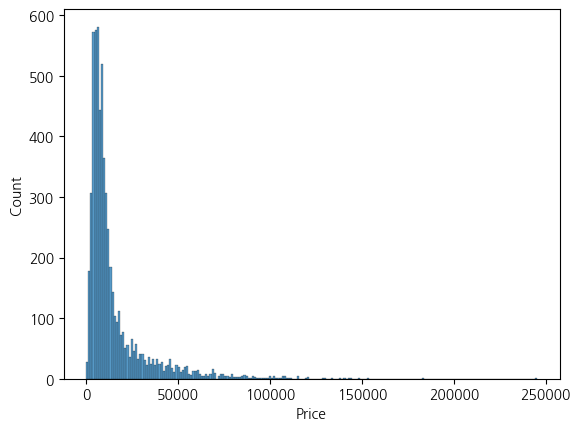

In [47]:
sns.histplot(df['Price'])
plt.show()

- 대부분이 50000 이하에 분포한다.
- 그래프가 정규성을 띄지 않는다 판단하여 정규분포를 띄도록 로그 변환 진행 후 새로운 파생 변수로 저장 + 기존 Price 컬럼 삭제

In [48]:
df['Price_log']=np.log(df['Price'])
df.drop("Price", axis=1, inplace=True)

<Axes: xlabel='Price_log', ylabel='Count'>

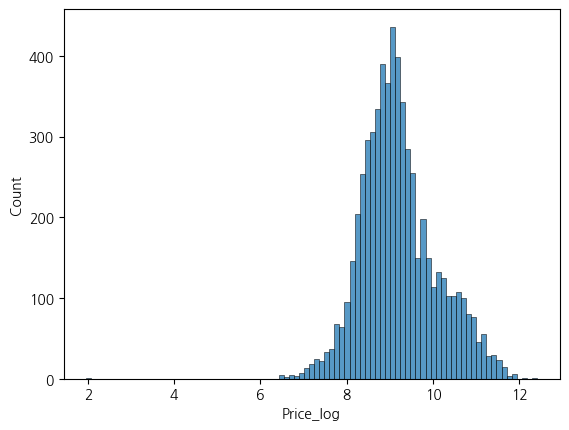

In [49]:
# 재확인
sns.histplot(df['Price_log'])

- 로그 변환을 통해 비대칭 분포를 보다 정규 분포의 형태에 가깝게 변형

<Axes: xlabel='Power', ylabel='Count'>

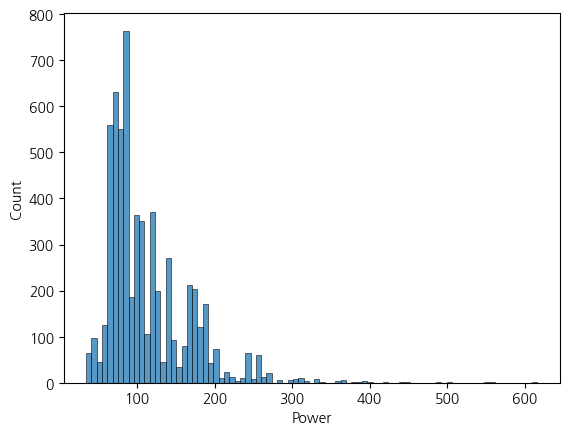

In [50]:
sns.histplot(df['Power'])

- 마찬가지로 정규분포의 형태로 띄게 하기 위해 로그 변환

In [51]:
df['Power_log']=np.log(df['Power'])
df.drop("Power", axis=1, inplace=True)

<Axes: xlabel='Power_log', ylabel='Count'>

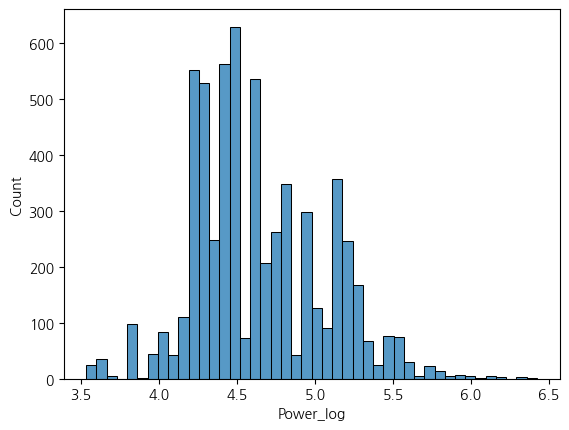

In [52]:
sns.histplot(df['Power_log'])

- 좀 더 정규분포에 가깝게 변형됨.

In [53]:
# 이상치 재확인
df.describe()

,Year,Kilometers_Driven,Mileage,Engine,Seats,Price_log,Power_log
count,6053.000000,6.053000e+03,6053.000000,6053.000000,6053.000000,6053.000000,6053.000000
mean,2013.551958,5.773449e+04,18.323215,1624.315876,5.283331,9.199538,4.638028
std,3.167314,9.096035e+04,4.365746,601.783463,0.804717,0.875582,0.416573
min,1998.000000,1.710000e+02,0.000000,624.000000,2.000000,1.957274,3.532226
25%,2012.000000,3.280700e+04,15.290000,1198.000000,5.000000,8.615890,4.317488
50%,2014.000000,5.200000e+04,18.480000,1495.000000,5.000000,9.092814,4.580877
75%,2016.000000,7.200000e+04,21.100000,1984.000000,5.000000,9.686331,4.927978
max,2019.000000,6.500000e+06,33.540000,5998.000000,10.000000,12.410130,6.423247


In [54]:
# Kilometers_Driven max 값이 약 650만 키로로 이상치로 판단됨 -> 제거
# 앞서 boxplot에서 한개로 파악되었으므로 바로 제거
df = df[df['Kilometers_Driven'] < 6500000]
df

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Size,Price_log,Power_log
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,5.0,Maruti,light,7.894572,4.063198
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,5.0,Hyundai,small,9.860684,4.837868
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,5.0,Honda,small,8.839033,4.485260
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,7.0,Maruti,small,9.126715,4.485936
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,5.0,Audi,mid,10.210778,4.947340
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7228,Pune,2016,41413,Diesel,Manual,First,27.28,1047.0,5.0,Tata,small,9.289401,4.234107
7231,Kochi,2017,39015,Petrol,Manual,First,17.00,1497.0,5.0,Ford,small,9.508571,4.798761
7232,Mumbai,2018,6000,Petrol,Manual,First,16.00,1368.0,5.0,Jeep,small,10.234177,5.075174
7235,Kochi,2017,21380,Diesel,Manual,First,24.30,1248.0,5.0,Maruti,small,9.692976,4.483003


In [55]:
# Mileage 열에서 min값이 0으로 이상치로 판단됨 -> 먼저 확인
# 데이터 수가 분석에 큰 영향을 주지 않을 것이라 판단하고 제거
df[df['Mileage'] == 0]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Size,Price_log,Power_log
14,Pune,2012,85000,Diesel,Automatic,Second,0.0,2179.0,5.0,Land,full,10.197157,4.744932
67,Coimbatore,2019,15369,Diesel,Automatic,First,0.0,1950.0,5.0,Mercedes-Benz,mid,10.909266,5.267858
544,Kochi,2019,13190,Petrol,Automatic,First,0.0,1950.0,5.0,Mercedes-Benz,mid,10.998261,5.200870
707,Pune,2014,120000,Diesel,Automatic,First,0.0,2987.0,5.0,Mercedes-Benz,full,10.736153,5.105945
962,Mumbai,2018,8682,Diesel,Automatic,First,0.0,1950.0,5.0,Mercedes-Benz,mid,11.011256,5.267858
996,Pune,2008,93000,Petrol,Manual,First,0.0,1086.0,5.0,Hyundai,small,7.706518,4.127134
1059,Hyderabad,2010,58163,Petrol,Manual,First,0.0,1086.0,5.0,Hyundai,small,8.231043,4.127134
1259,Bangalore,2010,125000,Diesel,Automatic,Second,0.0,2179.0,5.0,Land,full,9.732851,4.744932
1308,Bangalore,2014,33000,Diesel,Automatic,Second,0.0,2987.0,5.0,Mercedes-Benz,full,11.096156,5.105945
1354,Kochi,2011,20842,Petrol,Manual,First,0.0,1086.0,5.0,Hyundai,small,8.357407,4.127134


In [56]:
df=df[df['Mileage']!=0]

In [57]:
df[df['Mileage'] == 0] # 제거 확인

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Size,Price_log,Power_log


In [58]:
# Brand에서도 10개 이하로 분포하는 브랜드는 분석에 영향이 없을 것이라 판단하여 제거
# 한자리 수 차량 5개 제거 시작
brand_counts = df['Brand'].value_counts()
brand_counts

Maruti           1218
Hyundai          1072
Honda             614
Toyota            406
Volkswagen        320
Mercedes-Benz     311
Ford              298
Mahindra          278
BMW               267
Audi              239
Tata              192
Skoda             179
Renault           151
Chevrolet         120
Nissan             93
Land               51
Jaguar             43
Mitsubishi         34
Mini               29
Fiat               26
Volvo              21
Jeep               19
Datsun             17
Porsche            16
ISUZU               3
Force               3
Bentley             2
Ambassador          1
Lamborghini         1
Name: Brand, dtype: int64

In [59]:
# 브랜드 행을 brand_count로 map하고 행 추가
df['Brand_count'] = df['Brand'].map(brand_counts)
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Size,Price_log,Power_log,Brand_count
0,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,5.0,Maruti,light,7.894572,4.063198,1218
1,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,5.0,Hyundai,small,9.860684,4.837868,1072
2,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,5.0,Honda,small,8.839033,4.485260,614
3,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,7.0,Maruti,small,9.126715,4.485936,1218
4,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,5.0,Audi,mid,10.210778,4.947340,239


In [60]:
# brand_count 행에서 10개 미만이 있는지 query 함수로 필터링
filtered_df = df.query("Brand_count < 10")
print(filtered_df)

        Location  Year  Kilometers_Driven Fuel_Type Transmission Owner_Type  \
1221     Chennai  2003              80000    Diesel       Manual      Third   
2900      Jaipur  2017              34429    Diesel    Automatic      First   
3624  Coimbatore  2018              20422    Diesel       Manual      First   
4997     Chennai  2014              50000    Diesel       Manual      First   
5182     Kolkata  2014              41000    Diesel       Manual      First   
5206     Kolkata  2014              41000    Diesel       Manual      First   
5521   Hyderabad  2006              48000    Petrol    Automatic      First   
5781       Delhi  2011               6500    Petrol    Automatic      Third   
5979      Jaipur  2017              25000    Diesel       Manual      First   
6354   Bangalore  2008              31200    Petrol    Automatic     Second   

      Mileage  Engine  Seats        Brand   Size  Price_log  Power_log  \
1221     12.8  1489.0    5.0   Ambassador  small   7.635

In [61]:
# brand_count 수가 10개 미만인 열을 제거함
index_to_drop = df[df['Brand_count'] < 10].index
df.drop(index_to_drop, inplace=True)
print(df)

        Location  Year  Kilometers_Driven Fuel_Type Transmission Owner_Type  \
0         Mumbai  2010              72000       CNG       Manual      First   
1           Pune  2015              41000    Diesel       Manual      First   
2        Chennai  2011              46000    Petrol       Manual      First   
3        Chennai  2012              87000    Diesel       Manual      First   
4     Coimbatore  2013              40670    Diesel    Automatic     Second   
...          ...   ...                ...       ...          ...        ...   
7228        Pune  2016              41413    Diesel       Manual      First   
7231       Kochi  2017              39015    Petrol       Manual      First   
7232      Mumbai  2018               6000    Petrol       Manual      First   
7235       Kochi  2017              21380    Diesel       Manual      First   
7236       Kochi  2018              23955    Petrol       Manual      First   

      Mileage  Engine  Seats    Brand   Size  Price

In [62]:
# 조건 필터링으로 제거된지 확인 / 결과 empty
filtered_df = df.query("Brand_count < 10")
print(filtered_df)

Empty DataFrame
Columns: [Location, Year, Kilometers_Driven, Fuel_Type, Transmission, Owner_Type, Mileage, Engine, Seats, Brand, Size, Price_log, Power_log, Brand_count]
Index: []


In [63]:
# 다 사용한 brand_count는 필요없으므로 컬럼 제거
df.drop('Brand_count',axis=1,inplace=True)

## 3. EDA

### 변수 간 관계

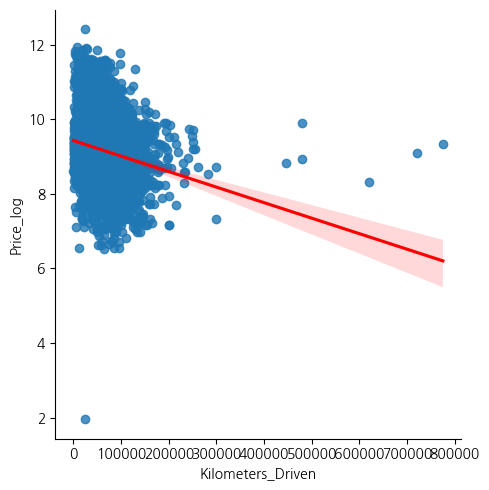

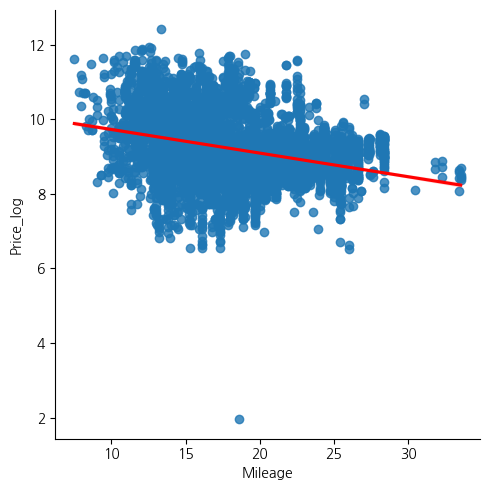

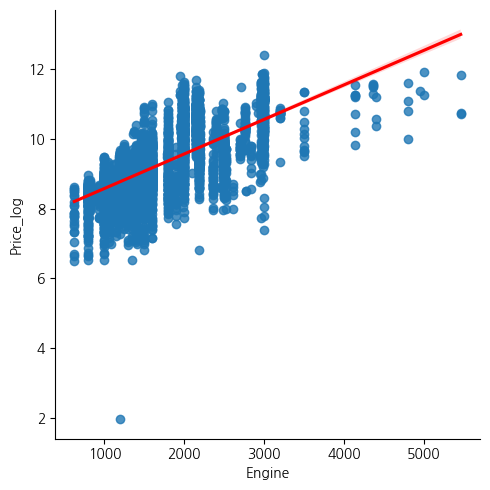

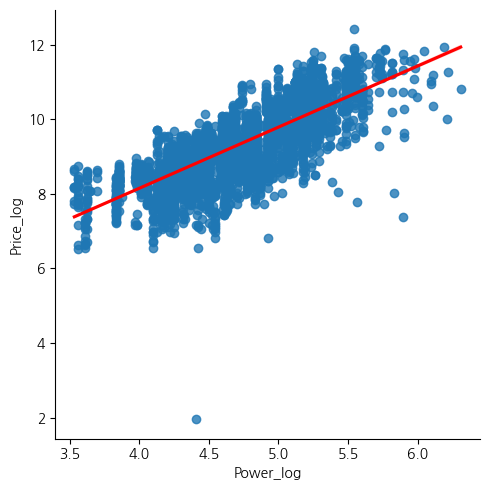

In [64]:
#fig, axs = plt.subplots(3, 2, figsize=(12, 9))
#axs = axs.flatten()

# sns.scatterplot(data=df, x='Brand', y='Price_log', ax=axs[0])
# sns.scatterplot(data=df, x='Kilometers_Driven', y='Price_log', ax=axs[1])
# sns.scatterplot(data=df, x='Mileage', y='Price_log', ax=axs[2])
# sns.scatterplot(data=df, x='Engine', y='Price_log', ax=axs[3])
# sns.scatterplot(data=df, x='Power_log', y='Price_log', ax=axs[4])
# sns.scatterplot(data=df, x='Seats', y='Price_log', ax=axs[5])

#sns.lmplot(data=df, x='Brand', y='Price_log')
sns.lmplot(data=df, x='Kilometers_Driven', y='Price_log',line_kws={'color':'red'})
sns.lmplot(data=df, x='Mileage', y='Price_log',line_kws={'color':'red'})
sns.lmplot(data=df, x='Engine', y='Price_log',line_kws={'color':'red'})
sns.lmplot(data=df, x='Power_log', y='Price_log',line_kws={'color':'red'})
#sns.lmplot(data=df, x='Seats', y='Price_log')


fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

변수 간 관계를 산점도를 통해 시각화하였다.

1. Power_log가 증가하면 Price_log 또한 선형적으로 증가하는 경향을 보인다. 출력이 높은 차량의 판매 금액이 높을 것이라고 판단하였다.
2. 차량의 Engine(배기량)이 판매금액에 영향을 끼치는 것으로 판단하였다. 배기량이 커질수록 차량의 판매 금액이 증가하는 경향을 보인다.

### 데이터 분포

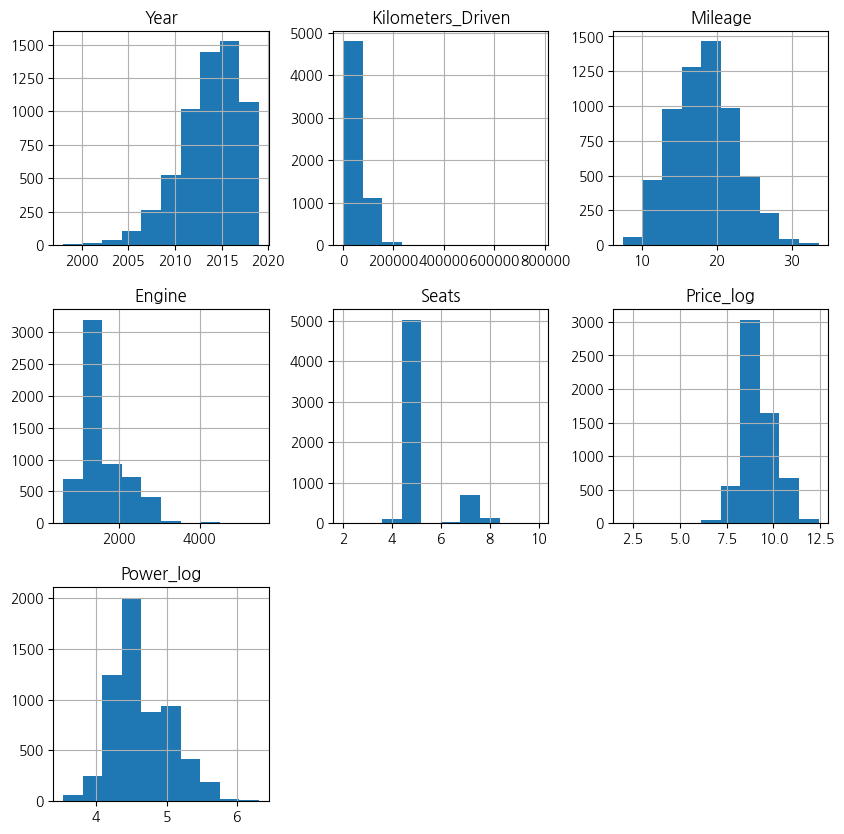

In [65]:
df.hist(figsize = (10, 10)) #히스토그램 - 데이터의 전반적인 분포를 파악
fig.subplots_adjust(wspace=0.4, hspace=0.8)

- 해석

### 상관관계

<Axes: >

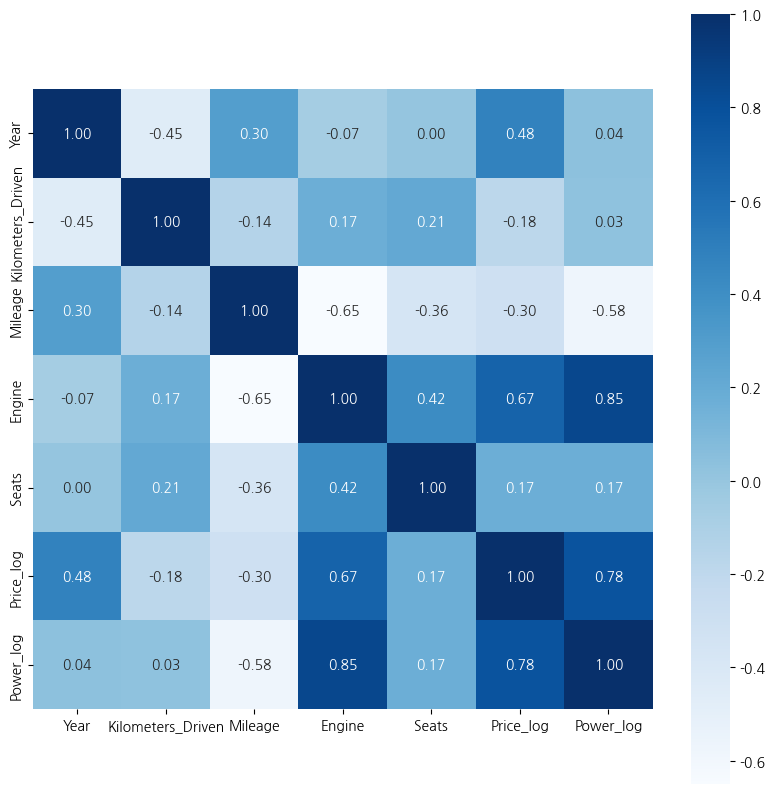

In [66]:
num = df.select_dtypes(include=np.number) 
plt.figure(figsize=(10, 10))
sns.heatmap(num.corr(), annot=True, square=True, fmt='.2f', annot_kws={'size': 10},cmap='Blues')

히트맵을 통해 수치형 변수간 상관관계를 시각화하였다.

1. 앞서 산점도를 통해 차량의 Power_log(차량의 출력)이 Price_log(판매금액)에 영향을 끼치는 것을 추측할 수 있었다. 실제로 차량 출력과 판매금액은 높은 상관관계를 보이는 것을 확인할 수 있다.
2. 차량의 Engine(배기량)이 증가하면 Price_log(판매금액)이 증가할 수 있다.
3. 

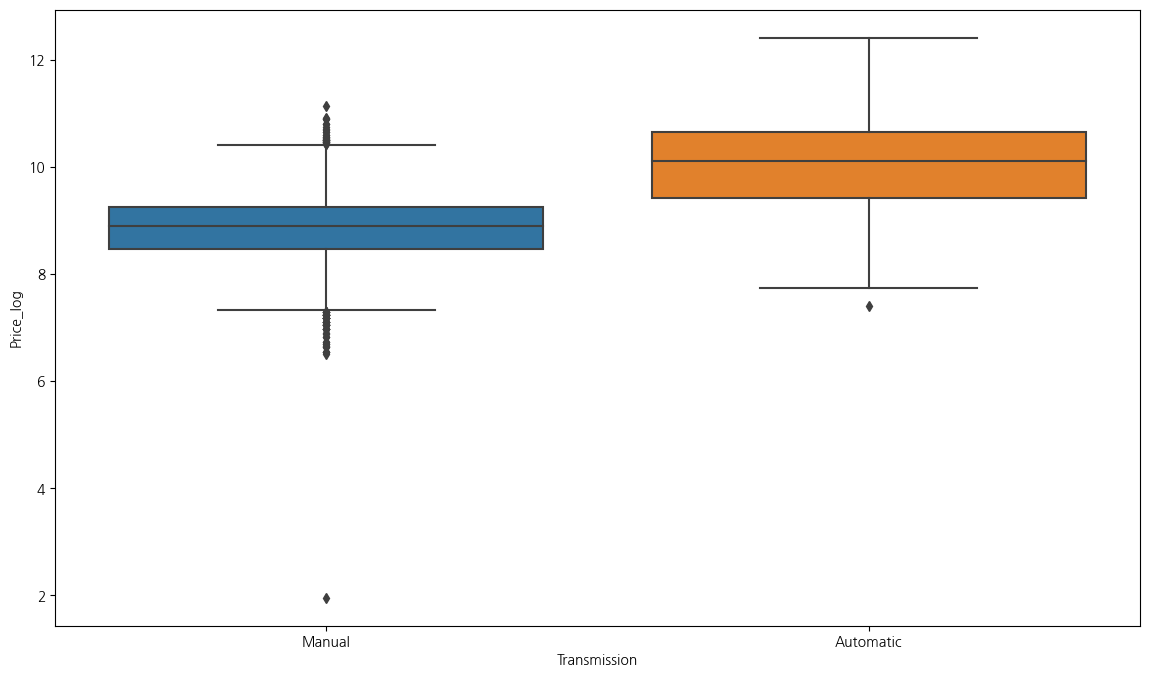

In [67]:
plt.figure(figsize=(14,8))
sns.boxplot(x='Transmission',y='Price_log',data=df)
plt.show()

차량의 Transmission에 따른 판매가격
- Automatic의 IQR이 Manual에 비해 높게 형성되어있다.
- 앞서 인도의 도로 사정과 가격 문제로 manual 차량이 더 선호되는 것으로 파악된다.
- 

Text(0.5, 1.0, 'Price Distribution by Location')

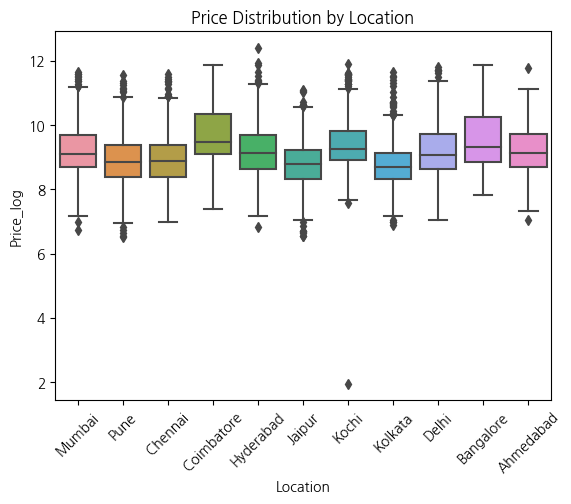

In [68]:
# Location 별 Price
sns.boxplot(x='Location', y='Price_log', data=df)
plt.xticks(rotation=45)  # X축 라벨을 45도 회전
plt.title('Price Distribution by Location')

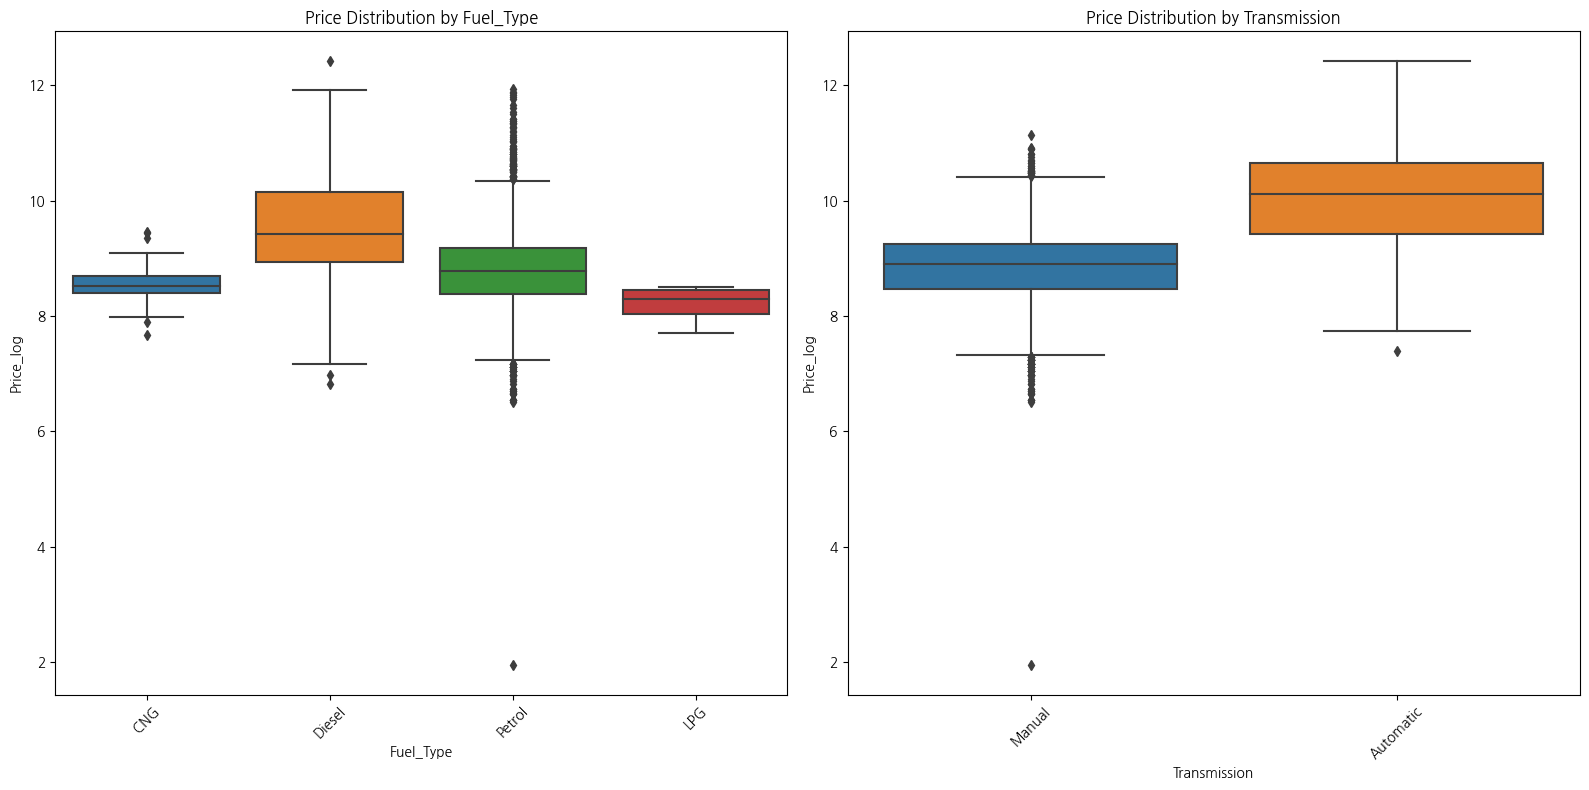

In [69]:
categorical_columns = ['Fuel_Type', 'Transmission']

# Subplots 생성
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(16, 8))

# 각 범주형 변수에 대해 Boxplot 생성
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='Price_log', data=df, ax=axes[i])
    axes[i].set_title(f'Price Distribution by {col}')
    axes[i].tick_params(axis='x', rotation=45)  # X축 라벨 회전

plt.tight_layout()
plt.show()

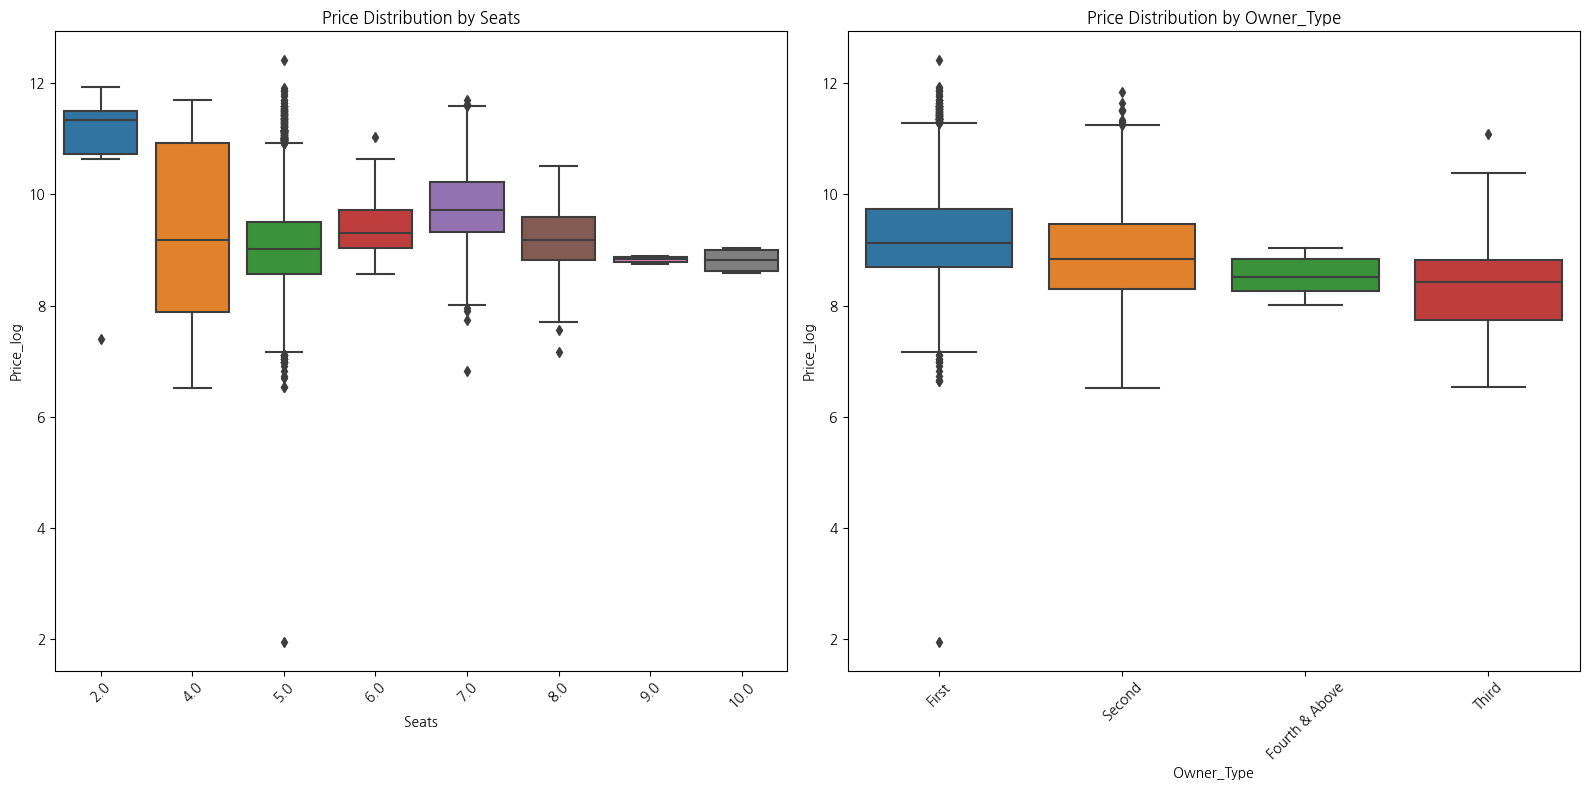

In [70]:
categorical_columns =['Seats','Owner_Type']
# Subplots 생성
fig, axes = plt.subplots(1, len(categorical_columns), figsize=(16, 8))

# 각 범주형 변수에 대해 Boxplot 생성
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='Price_log', data=df, ax=axes[i])
    axes[i].set_title(f'Price Distribution by {col}')
    axes[i].tick_params(axis='x', rotation=45)  # X축 라벨 회전

plt.tight_layout()
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'Maruti'),
  Text(1, 0, 'Hyundai'),
  Text(2, 0, 'Honda'),
  Text(3, 0, 'Audi'),
  Text(4, 0, 'Nissan'),
  Text(5, 0, 'Toyota'),
  Text(6, 0, 'Volkswagen'),
  Text(7, 0, 'Tata'),
  Text(8, 0, 'Land'),
  Text(9, 0, 'Mitsubishi'),
  Text(10, 0, 'Renault'),
  Text(11, 0, 'Mercedes-Benz'),
  Text(12, 0, 'BMW'),
  Text(13, 0, 'Mahindra'),
  Text(14, 0, 'Ford'),
  Text(15, 0, 'Porsche'),
  Text(16, 0, 'Datsun'),
  Text(17, 0, 'Jaguar'),
  Text(18, 0, 'Volvo'),
  Text(19, 0, 'Chevrolet'),
  Text(20, 0, 'Skoda'),
  Text(21, 0, 'Mini'),
  Text(22, 0, 'Fiat'),
  Text(23, 0, 'Jeep')])

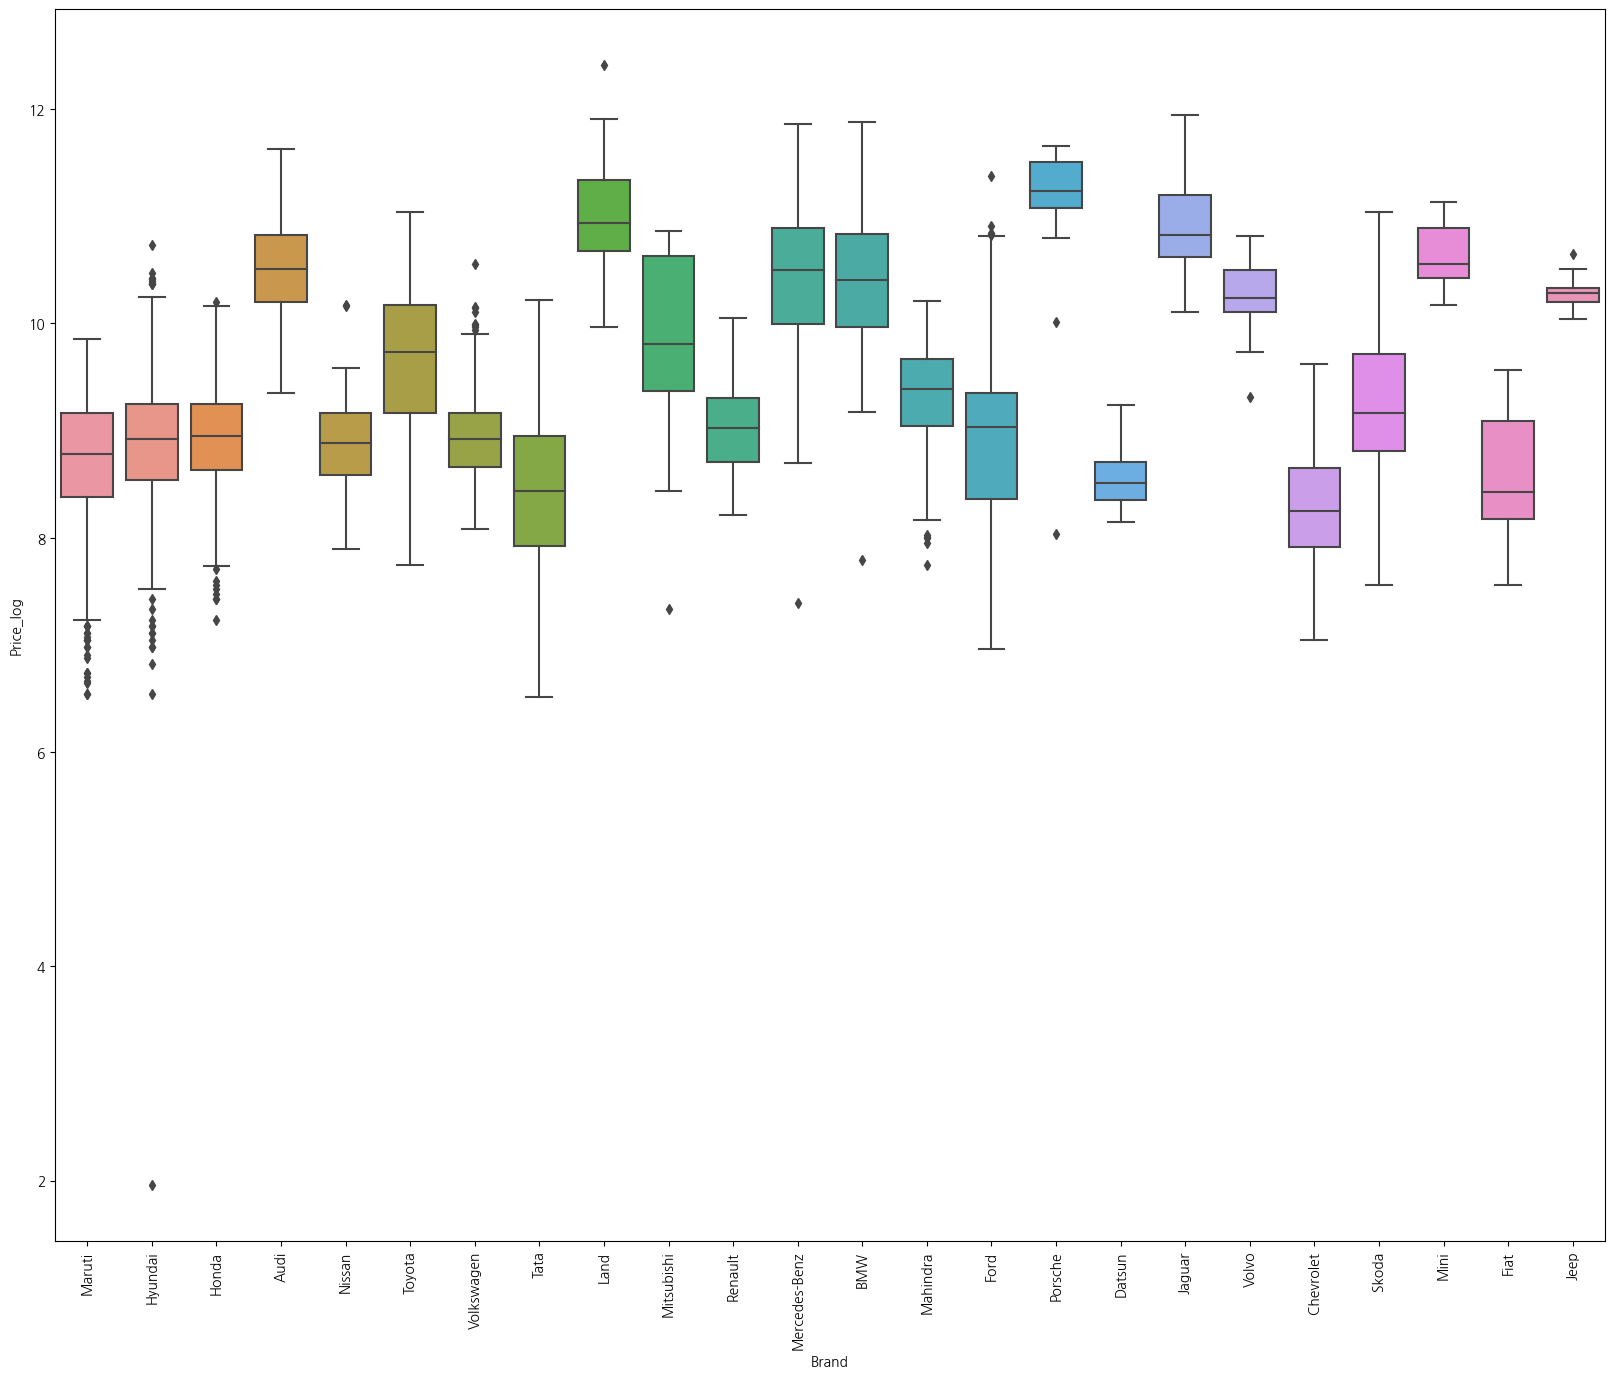

In [71]:
plt.figure(figsize=(20,16))
sns.boxplot(x='Brand',y='Price_log',data=df)
plt.xticks(rotation=90)

In [72]:
p = df['Price_log'].min()
df[df['Price_log'] == p]

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Seats,Brand,Size,Price_log,Power_log
7236,Kochi,2018,23955,Petrol,Manual,First,18.6,1197.0,5.0,Hyundai,small,1.957274,4.40501


In [73]:
# 이상치라 판단하여 제거
df=df[df['Price_log'] != p]
df['Price_log'].min()

6.51397167564781

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Mumbai'),
  Text(1, 0, 'Pune'),
  Text(2, 0, 'Chennai'),
  Text(3, 0, 'Coimbatore'),
  Text(4, 0, 'Hyderabad'),
  Text(5, 0, 'Jaipur'),
  Text(6, 0, 'Kochi'),
  Text(7, 0, 'Kolkata'),
  Text(8, 0, 'Delhi'),
  Text(9, 0, 'Bangalore'),
  Text(10, 0, 'Ahmedabad')])

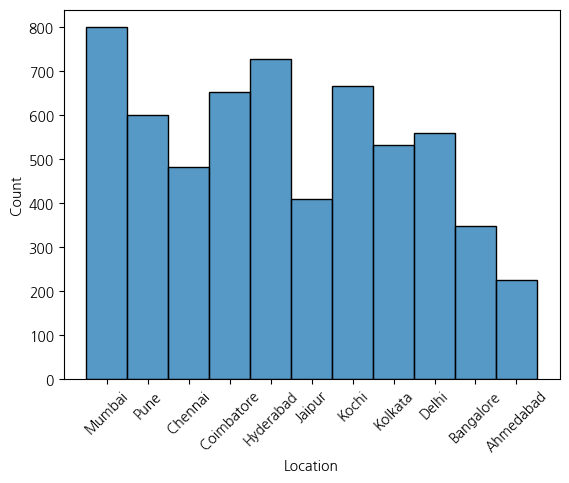

In [74]:

sns.histplot(df['Location'])
plt.xticks(rotation=45)

- 도시 상 가격의 큰 차이는 보이지 않는다.

종합적으로 분석해보았을 때, ~가지 상관관계를 고려해볼 수 있다.
1) Engine(배기량)과 가격은 양의 상관 관계를 보인다.
2) Power(최대출력)과 가격은 양의 상관 관계를 보인다.
3) 


## 4. 모델링

### 데이터 분리

In [75]:
df_train, df_test = train_test_spli변수 간 상관관계 클수록 색이 진하고, 상관계수가 양수이면 빨간색, 음수이면 파란색 계열로 표현한다.

Price_Log와 Power_Log 상관계수 : 0.78 -> Power_log와 Price_log는 강한 양의 상관관계를 가지고 있다. 차량의 엔진 출력(Power_log)이 높을수록 가격(Price_log)도 높은 경향이 있음을 의미한다.

Price_Log와 Engine 상관계수 : 0.68 -> Engine과 Price_log는 강한 양의 상관관계를 가지고 있다.. 이는 엔진의 크기나 배기량(Engine)이 클수록 가격이 높아질 경향이 있음을 의미한다.

Engine과 Power_Log 상관계수 : 0.85 -> Engine과 Power_log는 매우 강한 양의 상관관계를 가지고 있다. 이는 엔진 크기나 배기량이 클수록 출력(Power_log)도 높다는 것을 의미한다.

Mileage와 Engine 상관계수 : -0.65 -> Power_log와 Price_log는 강한 양의 상관관계를 가지고 있다. 일반적으로 엔진이 클수록 연비(Mileage)가 낮아지는 경향이 있음을 나타낸다.

Mileage와 Power_Log 상관계수 : -0.58 -> Mileage와 Power_log도 강한 음의 상관관계를 보인다. 주행 거리가 많을수록 차량 가격이 약간 낮아질 수 있음을 나타내지만, 매우 강한 상관관계는 아니다.

Kilometers_Driven과 Price_Log 상관계수 : -0.18 -> Kilometers_Driven과 Price_log는 약한 음의 상관관계를 가지고 있다. 차량의 엔진 출력(Power_log)이 높을수록 가격(Price_log)도 높은 경향이 있음을 의미한다.

Kilometers_Driven과 다른 변수들 -> 다른 변수들과의 상관계수는 대부분 매우 낮거나, 거의 상관관계가 없다. 이는 주행 거리(Kilometers_Driven)가 이들 변수들과 큰 관련이 없다는 것을 의미한다.

종합적으로 이 상관행렬은 차량의 출력과 엔진 크기가 가격에 큰 영향을 미치며, 연비는 이들 변수와 반비례 관계가 있음을 나타낸다.t(df,test_size=0.3)

SyntaxError: invalid syntax (1853947786.py, line 1)

### Logistic Regression

In [ ]:
reg_model = smf.ols(formula = "Price_log ~ Year + Kilometers_Driven + Mileage + Engine + Power_log ", data = df_train)
reg_result = reg_model.fit()
print(reg_result.summary())

In [ ]:
cols = df_train.select_dtypes(['int','float']).columns
df_train_const = add_constant(df_train[cols])
df_vif = pd.DataFrame()
df_vif['variable'] = df_train_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_train_const.values, i) for i in range(df_train_const.shape[1])]
df_vif.sort_values('VIF', ascending = True).round(2)

# VIF 검사 상 이상 X

- 해석

로그 변환된 가격(Price_log)을 종속 변수로 사용하고, 연도(Year), 주행 거리(Kilometers_Driven), 연비(Mileage), 엔진 크기(Engine), 그리고 로그 변환된 출력(Power_log)을 독립 변수로 사용한 OLS(최소자승법) 회귀 모델

1. R-squared: 0.842 / Adj. R-squared: 0.842
-> 높은 설명력을 가진다.

2. F-statistic: 4485 / Prob (F-statistic): 0.00
p-value가 0.05보다 작으므로 이 모델이 통계적으로 매우 유의미하다는 것을 의미한다.

3. Coefficients (회귀 계수)
- Year (연도): 0.1222
연도가 1년 증가할 때마다 Price_log는 약 0.1222만큼 증가합니다. 이는 연식이 높은 차일수록 가격이 높아질 가능성이 있음을 의미한다.
- Kilometers_Driven (주행 거리): -7.28e-07
주행 거리가 1km 증가할 때 Price_log는 약 7.28e-07만큼 감소합니다. 이는 주행 거리가 많을수록 가격이 약간 낮아질 가능성이 있음을 의미한다.
- Mileage (연비): 0.0133
연비가 1 단위 증가할 때 Price_log는 약 0.0133만큼 증가한다. 연비가 좋을수록 차량 가격이 높아질 가능성이 있음을 나타낸다.
- Engine (엔진 크기): 0.0004
엔진 크기가 1 단위 증가할 때 Price_log는 0.0004만큼 증가한다. 엔진 크기가 클수록 차량 가격이 높을 가능성이 있음을 나타낸다.
- Power_log (로그 변환된 출력): 1.2172
출력이 1 단위 증가할 때 Price_log는 약 1.2172만큼 증가한다. 출력이 클수록 차량 가격이 크게 증가할 가능성이 있음을 나타낸다.

4. t-Statistic과 P>|t| (t-통계량과 p-값)
각 변수의 t-통계량과 p-값을 보면, 모든 변수들이 통계적으로 유의미하다. (p-값이 모두 0.05 이하).

5. 다중공선성 (VIF >= 10)
대부분의 변수들의 VIF 값이 10 미만으로 다중공선성은 심각하지 않다.



### 연속형 변수 vs 연속형 변수 : 상관분석

In [ ]:
# 상관 분석
variables = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power_log']

# 변수들 간의 상관 계수 행렬 계산
corr_matrix = df[variables + ['Price_log']].corr()

# Heatmap으로 상관 계수 행렬 시각화
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

# Price_log과 각 변수들 간의 상관 계수
print('Correlation with Price_log:')
print(corr_matrix['Price_log'])

변수 간 상관관계 클수록 색이 진하고, 상관계수가 양수이면 빨간색, 음수이면 파란색 계열로 표현한다.

1. Price_Log와 Power_Log 상관계수 : 0.78
-> Power_log와 Price_log는 강한 양의 상관관계를 가지고 있다. 차량의 엔진 출력(Power_log)이 높을수록 가격(Price_log)도 높은 경향이 있음을 의미한다.

2. Price_Log와 Engine 상관계수 : 0.68
-> Engine과 Price_log는 강한 양의 상관관계를 가지고 있다.. 이는 엔진의 크기나 배기량(Engine)이 클수록 가격이 높아질 경향이 있음을 의미한다.

3. Engine과 Power_Log 상관계수 : 0.85
-> Engine과 Power_log는 매우 강한 양의 상관관계를 가지고 있다. 이는 엔진 크기나 배기량이 클수록 출력(Power_log)도 높다는 것을 의미한다.

4. Mileage와 Engine 상관계수 : -0.65
-> Power_log와 Price_log는 강한 양의 상관관계를 가지고 있다. 일반적으로 엔진이 클수록 연비(Mileage)가 낮아지는 경향이 있음을 나타낸다.

5. Mileage와 Power_Log 상관계수 : -0.58
-> Mileage와 Power_log도 강한 음의 상관관계를 보인다. 주행 거리가 많을수록 차량 가격이 약간 낮아질 수 있음을 나타내지만, 매우 강한 상관관계는 아니다.

6. Kilometers_Driven과 Price_Log 상관계수 :  -0.18
-> Kilometers_Driven과 Price_log는 약한 음의 상관관계를 가지고 있다.  차량의 엔진 출력(Power_log)이 높을수록 가격(Price_log)도 높은 경향이 있음을 의미한다.

7. Kilometers_Driven과 다른 변수들 
-> 다른 변수들과의 상관계수는 대부분 매우 낮거나, 거의 상관관계가 없다. 이는 주행 거리(Kilometers_Driven)가 이들 변수들과 큰 관련이 없다는 것을 의미한다.

종합적으로 이 상관행렬은 차량의 출력과 엔진 크기가 가격에 큰 영향을 미치며, 연비는 이들 변수와 반비례 관계가 있음을 나타낸다.


### 범주형 vs 범주형 비교 : 카이제곱 검정

In [ ]:
from scipy.stats import chi2_contingency

# 범주형 변수 선택
categorical_variables = ['Fuel_Type', 'Transmission', 'Seats', 'Owner_Type', 'Brand']

# 각 변수와 Price_log 간의 독립성을 평가하는 카이제곱 검정 수행
for var in categorical_variables:
    contingency_table = pd.crosstab(df[var], df['Price_log'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    
    print(f'Chi-square test for {var}:')
    print('Chi-square statistic:', chi2)
    print('p-value:', p_value)
    print()

- 해석

1. Fuel_Type: p-value가 0.9995로 매우 커서 다른 변수들과 유의미한 관계가 없고, 독립적이다.

2. Transmission, Seats, Brand: p-value가 매우 작아 유의미한 관계가 있고, 독립적이지 않다.

3. Owner_Type: p-value가 1.0으로, 다른 변수들과 유의미한 관계가 없고, 독립적이다.

즉, Transmission, Seats, Brand는 중요한 변수로 고려해야 하고, Fuel_Type과 Owner_Type은 독립적이어서 상대적으로 영향이 적다.



## 범주형 vs 연속형 : ANOVA

In [ ]:
# 범주형 변수 선택
categorical_variables = ['Fuel_Type', 'Transmission', 'Seats', 'Owner_Type', 'Brand']

# 각 범주형 변수와 Price_log 간의 ANOVA 검정 수행
for var in categorical_variables:
    formula = f'Price_log ~ C({var})'  # ANOVA 모델 formula 생성
    model = ols(formula, data=df).fit()  # ANOVA 모델 피팅
    anova_table = sm.stats.anova_lm(model)  # ANOVA 결과 테이블 생성
    
    print(f'ANOVA test for {var}:')
    print(anova_table)
    print()

- 해석

1. Fuel_Type: F-통계량: 451.61 / p-value: 1.320279e-264
-> 연료 유형(Fuel_Type)에 따라 그룹 간 평균 차이가 통계적으로 유의미하다. 즉, 연료 유형이 결과 변수에 영향을 미친다고 할 수 있다.

2. Transmission: F-통계량: 3574.71 / p-value: 0.0
-> 변속기 유형(Transmission)에 따른 그룹 간 평균 차이가 통계적으로 유의미하다. 즉, 변속기 유형도 결과 변수에 영향을 미친다고 할 수 있다.

3. Seats: F-통계량: 68.07 / p-value: 5.897999e-95
-> 좌석 수(Seats)에 따른 그룹 간 평균 차이도 통계적으로 유의미하다. 즉, 좌석 수가 결과 변수에 영향을 미친다고 할 수 있다.

4. Owner_Type: F-통계량: 77.07 / p-value: 6.479045e-49
-> 소유자 유형(Owner_Type)에 따른 그룹 간 평균 차이도 통계적으로 유의미하다. 즉, 소유자 유형이 결과 변수에 영향을 미친다고 할 수 있다.

5. Brand: F-통계량: 326.32 / p-value: 0.0
-> 브랜드(Brand)에 따른 그룹 간 평균 차이도 통계적으로 유의미하다. 즉, 브랜드가 결과 변수에 영향을 미친다고 할 수 있다.

모든 변수(Fuel_Type, Transmission, Seats, Owner_Type, Brand)에서 매우 낮은 p-value가 나타났으며, 이는 각 변수별로 그룹 간 평균 차이가 통계적으로 유의미함을 의미한다. 즉, 이 변수들은 모두 결과 변수에 중요한 영향을 미친다고 해석할 수 있다.

## 범주형 변수 변환

In [ ]:
df['Location'].unique()

In [ ]:
loc = df['Location'].values
list1=['Mumbai', 'Pune', 'Chennai', 'Coimbatore', 'Hyderabad', 'Jaipur',
       'Kochi', 'Kolkata', 'Delhi', 'Bangalore', 'Ahmedabad']

In [ ]:
#Owner_Type값을 수치형으로 변환
#re_Owner_Type = {'First': 1, 'Second': 2, 'Third': 3, 'Fourth & Above': 4}
#df['Owner_Type'] = df['Owner_Type'].map(re_Owner_Type)

# Fuel_Type의 데이터 값을 0, 1, 2, 3, 4로 변경
# Diesel -> 0, Petrol -> 1, CNG -> 2, 'LPG' -> 3, 'Electric' -> 4
df['Fuel_Type'] = df['Fuel_Type'].replace('Diesel', 0)
df['Fuel_Type'] = df['Fuel_Type'].replace('Petrol', 1)
df['Fuel_Type'] = df['Fuel_Type'].replace('CNG', 2)
df['Fuel_Type'] = df['Fuel_Type'].replace('LPG', 3)
df['Fuel_Type'] = df['Fuel_Type'].replace('Electric', 4)

# Transmission의 데이터 값을 1, 2로 변경
# Manual -> 1, Automatic -> 2
df['Transmission'] = df['Transmission'].replace('Manual', 1)
df['Transmission'] = df['Transmission'].replace('Automatic', 2)

#df['Location']=df['Location'].replace({"Mumbai":0,})

for i,l in enumerate(list1):
    df['Location'] = df['Location'].replace({l: i})

df['Fuel_Type'] = df['Fuel_Type'].astype('int64') # 타입 변환
df['Transmission'] = df['Transmission'].astype('int64')

df['Size']=df['Size'].replace({'light':0, 'small':1,'mid':2,'full':3})

In [ ]:
from sklearn.preprocessing import LabelEncoder #Brand 데이터 값 수치형으로 변환

le = LabelEncoder()
df['Brand'] = le.fit_transform(df['Brand'])

brand_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print(brand_mapping)

In [ ]:
le = LabelEncoder()
df['Owner_Type'] = le.fit_transform(df['Owner_Type'])


In [ ]:
df['Location'].value_counts()

In [ ]:
df_raw_y = df['Price_log']
df_raw_x = df.drop(['Price_log'], axis = 1, inplace = False)

In [ ]:
# 데이터 분할(train, test 데이터 7:3 비율로 분할)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))    

In [ ]:
df_train_x['Owner_Type'].unique()

In [ ]:
# 기본 옵션으로 모델 생성
tree_uncustomized = DecisionTreeRegressor()
tree_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))

## Randomforest

In [ ]:
rf_uncustomized = RandomForestRegressor()
rf_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(rf_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(rf_uncustomized.score(df_test_x, df_test_y)))

## GradientBoosting

In [ ]:
gb_uncustomized = GradientBoostingRegressor()
gb_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(gb_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(gb_uncustomized.score(df_test_x, df_test_y)))

In [ ]:
para_n_tree = [n_tree * 10 for n_tree in range(1, 11)]
para_leaf = [n_leaf * 1 for n_leaf in range(1, 21)]
para_split = [n_split * 2 for n_split in range(2, 21)]
para_depth = [depth for depth in range(1, 11)]
para_lr = [lr * 0.1 for lr in range(1, 10)]

estimator = GradientBoostingRegressor()

param_grid = {"criterion": ["mse","friedman_mse","mae"], "max_features" : [1.0],
                 "max_depth" : para_depth, "min_samples_split" : para_split, "min_samples_leaf" : para_leaf,
             "n_estimators" : para_n_tree,'learning_rate':para_lr}

grid_dt = GridSearchCV(estimator, param_grid, scoring = "r2", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model : \n{}".format(grid_dt.best_estimator_))
print("\n best parameter : \n {}".format(grid_dt.best_params_))
print("\n best score : \n {}".format(grid_dt.best_score_.round(3)))
